<a href="https://colab.research.google.com/github/cderamond/mba_UTFSM_finanzas/blob/caso_final/casoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 2 (50 puntos)

Descargar desde https://finance.yahoo.com/ los precios históricos mensuales de
10 acciones (marzo 2011 a marzo 2022). Las acciones deben ser (transarse) en
Estados Unidos y como máximo 3 acciones deben corresponder al mismo sector
industrial. A partir de los datos mensuales, las estadísticas de cada acción y la correlación entre cada par de ellas:



### Preparación y cálculos

In [2]:
!pip install yfinance --upgrade --no-cache-dir
!pip install PyPortfolioOpt

     |████████████████████████████████| 6.4 MB 15.3 MB/s 
     |████████████████████████████████| 63 kB 32.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 61 kB 6.4 MB/s 
     |████████████████████████████████| 2.8 MB 34.6 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-

In [248]:
# setting environment
import numpy as np
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import seaborn as sns

In [4]:
# bajar stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'KO', 'AMZN', 'GM', 'F', 'BRK-B', 'DIS']
start_date = '2011-03-01'
end_date = '2022-03-30'

# bajamos la data de todas las acciones
data = yf.download(tickers, start_date, end_date, group_by='ticker')
# ahora las del SP500, VOO ETF como benchmark
sp= yf.download('VOO', start_date, end_date, group_by='ticker')

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# filtrar los datos
dataadj = data.loc[:,(slice(None),'Adj Close')]
# revisar la estructura de datos
dataadj.dtypes

AAPL   Adj Close    float64
GOOGL  Adj Close    float64
TSLA   Adj Close    float64
MSFT   Adj Close    float64
AMZN   Adj Close    float64
DIS    Adj Close    float64
GM     Adj Close    float64
KO     Adj Close    float64
F      Adj Close    float64
BRK-B  Adj Close    float64
dtype: object

In [7]:
# cambio porcentual en log
dataadj = (dataadj.pct_change().apply(lambda x: np.log(1+x))
            .dropna()
            )
dataadj

,AAPL,GOOGL,TSLA,MSFT,AMZN,DIS,GM,KO,F,BRK-B
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
Date,,,,,,,,,,
2011-03-02,0.008012,0.000050,0.003336,-0.003063,0.015112,0.006954,-0.002126,-0.007422,0.000000,-0.002702
2011-03-03,0.020909,0.014492,0.014056,0.004591,0.004466,0.017858,0.004552,0.017539,0.006798,0.019567
2011-03-04,0.001223,-0.014775,0.023931,-0.009588,-0.006503,-0.011869,-0.019566,-0.005506,-0.023305,-0.013937
2011-03-07,-0.012973,-0.015030,-0.000401,-0.008903,-0.015202,-0.012245,-0.021533,0.000154,-0.028845,-0.005395
2011-03-08,0.001125,0.001098,-0.011290,0.007360,-0.013037,0.004175,0.031670,0.006419,0.032307,0.015287
...,...,...,...,...,...,...,...,...,...,...
2022-03-23,0.008200,-0.011451,0.005148,-0.015144,-0.009022,-0.017786,-0.017660,-0.006601,-0.024283,-0.005071
2022-03-24,0.022425,0.023560,0.014714,0.015276,0.001477,0.009545,0.012936,0.009557,0.008953,0.012020


### Representaciones gráficas

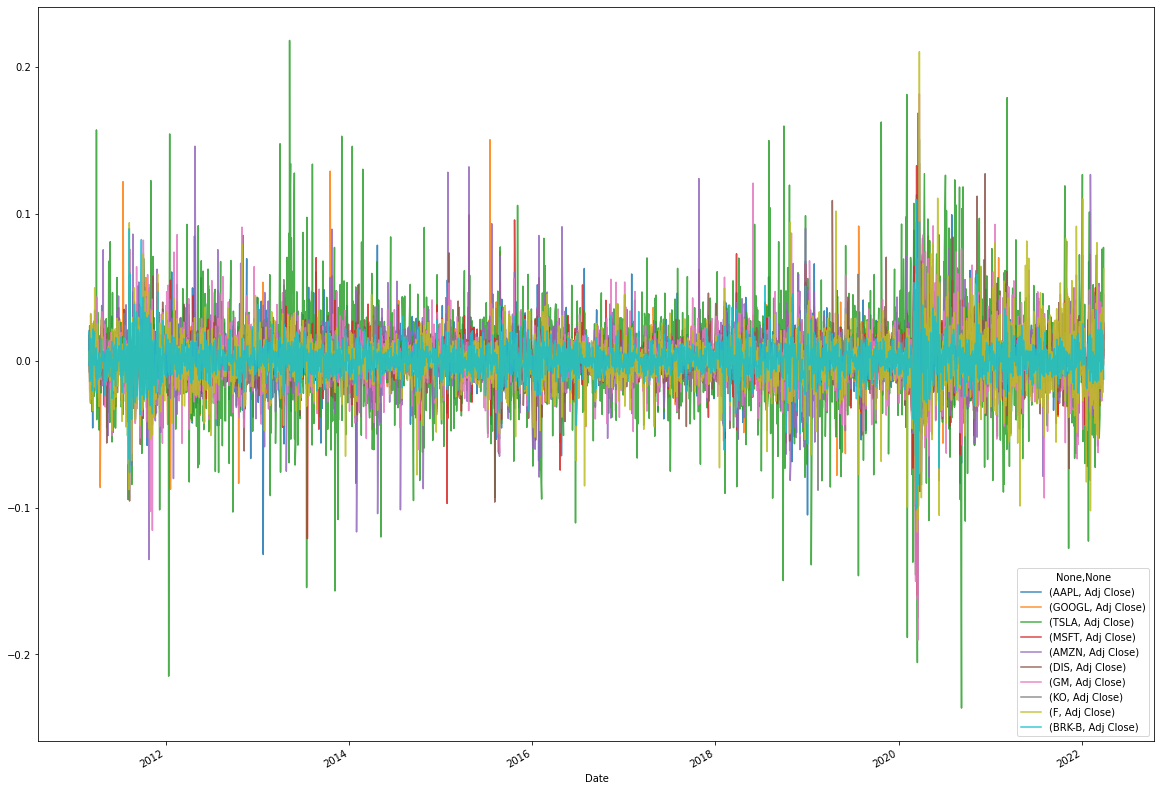

In [8]:
# gráfica de rentabilidades
dataadj.plot(figsize=(20,15), alpha=.85)

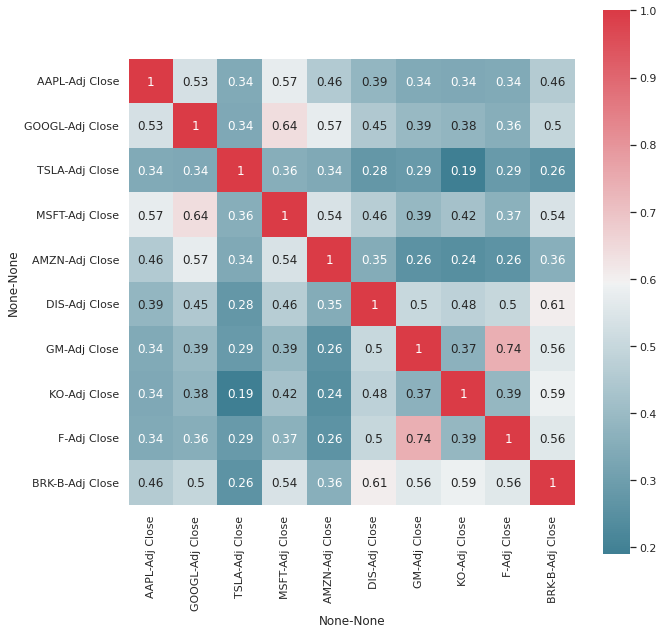

In [9]:
# representación matriz de correlaciones
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(dataadj.corr(), annot=True, 
            mask=np.zeros_like(dataadj.corr(), dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True,
            )

A destacar:
* Alta correlación entre Ford [F](https://g.co/finance/F:NYSE)
y [GM](https://www.google.com/finance/quote/gm:nyse)
, sin embargo, vemos que Tesla [$TSLA](https://www.google.com/finance/quote/tsla:nasdaq) es prácticamente no relacionada.
* [MSFT](https://www.google.com/finance/quote/MSFT:NASDAQ) y  [GOOGL](https://www.google.com/finance/quote/GOOGL:NASDAQ) también presentan una relación destacable.

### Análisis varianza

In [10]:
dataadj.describe()

,AAPL,GOOGL,TSLA,MSFT,AMZN,DIS,GM,KO,F,BRK-B
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
count,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000
mean,0.001011,0.000806,0.001949,0.000977,0.001074,0.000475,0.000214,0.000358,0.000198,0.000512
std,0.017841,0.016290,0.034911,0.016120,0.019769,0.015884,0.021437,0.011139,0.020320,0.012373
min,-0.137708,-0.123685,-0.236518,-0.159453,-0.135325,-0.139085,-0.190227,-0.101728,-0.116674,-0.100838
25%,-0.007335,-0.006589,-0.014781,-0.006582,-0.008389,-0.006470,-0.010190,-0.004515,-0.009473,-0.005465
50%,0.000887,0.000931,0.001266,0.000695,0.001101,0.000610,0.000282,0.000488,0.000000,0.000481
75%,0.010400,0.008910,0.018901,0.009008,0.011220,0.007776,0.010573,0.005891,0.009895,0.006536
max,0.113158,0.150645,0.218292,0.132929,0.146225,0.134639,0.181848,0.062783,0.210596,0.109840


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a8446c450>,
      dtype=object)

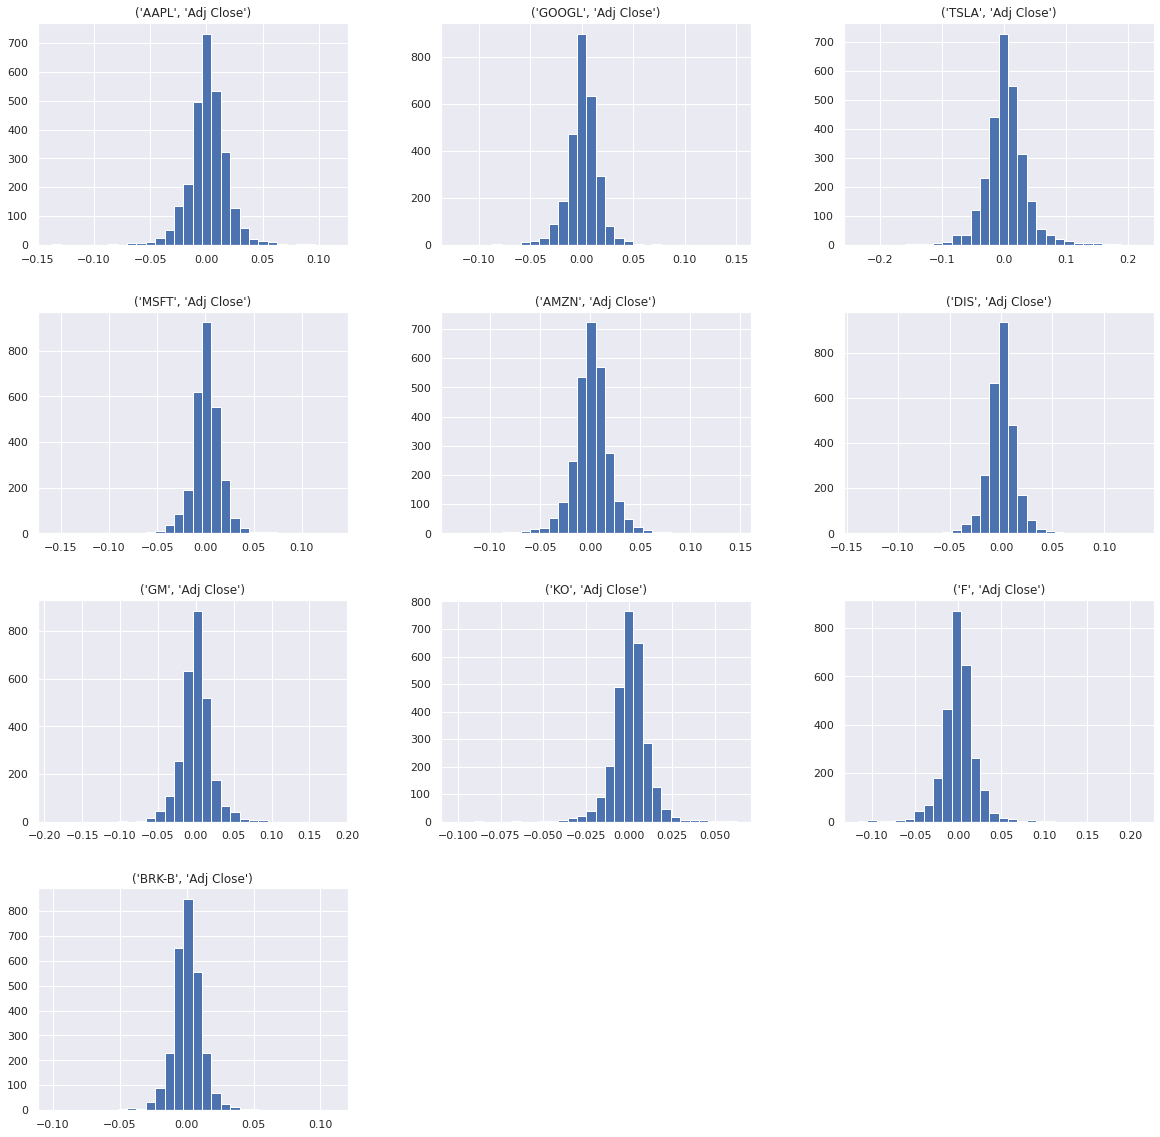

In [11]:
dataadj.hist(bins=50, figsize=(20, 20))

## A) Describa los principales negocios, riesgos e industria a la que pertenece.



Industria seleccionada: **Automotriz** 
*   Tesla $TSLA

*   General Motors $GM

*   Ford $F

### Estadísticas

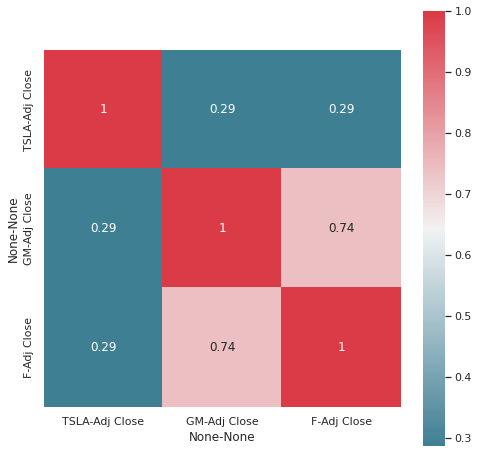

In [20]:
auto = dataadj.loc[:, (['TSLA', 'GM', 'F'], slice(None))]
# Matriz de correlaciones
sns.set(rc={"figure.figsize":(8, 8)})
sns.heatmap(auto.corr(), annot=True, 
            mask=np.zeros_like(auto.corr(), dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True,
            )

In [16]:
# Matriz Covarianza
dataadj.cov()

,,AAPL,GOOGL,TSLA,MSFT,AMZN,DIS,GM,KO,F,BRK-B
,,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
AAPL,Adj Close,0.000318,0.000155,0.000213,0.000165,0.000161,0.000109,0.000131,0.000067,0.000125,0.000101
GOOGL,Adj Close,0.000155,0.000265,0.000191,0.000168,0.000185,0.000116,0.000137,0.000069,0.000118,0.000100
TSLA,Adj Close,0.000213,0.000191,0.001219,0.000201,0.000234,0.000153,0.000215,0.000074,0.000204,0.000112
MSFT,Adj Close,0.000165,0.000168,0.000201,0.000260,0.000172,0.000119,0.000136,0.000076,0.000120,0.000108
AMZN,Adj Close,0.000161,0.000185,0.000234,0.000172,0.000391,0.000110,0.000110,0.000054,0.000105,0.000088
DIS,Adj Close,0.000109,0.000116,0.000153,0.000119,0.000110,0.000252,0.000170,0.000085,0.000161,0.000119
GM,Adj Close,0.000131,0.000137,0.000215,0.000136,0.000110,0.000170,0.000460,0.000088,0.000323,0.000149
KO,Adj Close,0.000067,0.000069,0.000074,0.000076,0.000054,0.000085,0.000088,0.000124,0.000088,0.000081
F,Adj Close,0.000125,0.000118,0.000204,0.000120,0.000105,0.000161,0.000323,0.000088,0.000413,0.000141


### Volatilidad


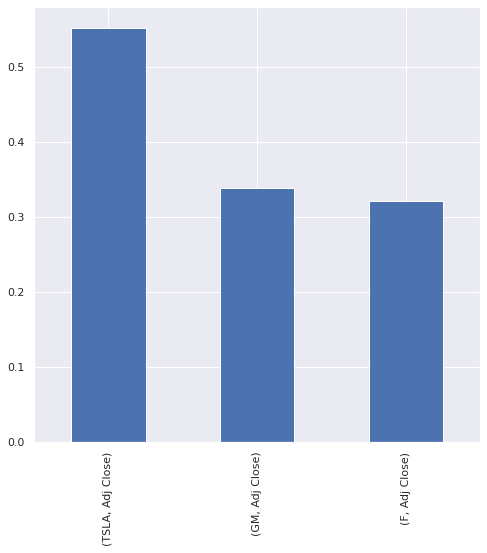

In [100]:
# Volatilidad anualizada a 252 días de trading
auto.std().apply(lambda x: x*np.sqrt(252)).plot(kind='bar')

### Rentabilidad esperada

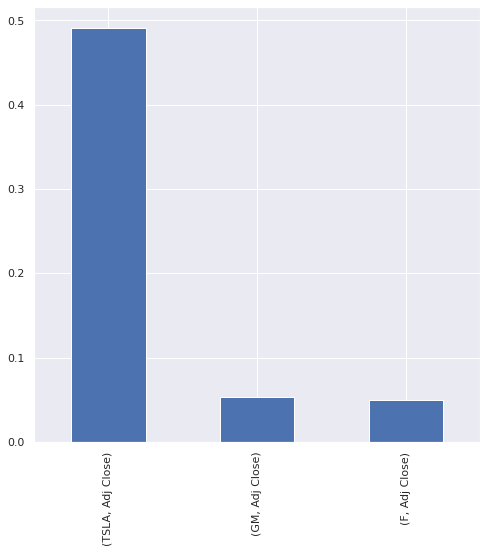

In [101]:
auto.mean().apply(lambda x: x*252).plot(kind='bar')

## B) Determine la rentabilidad y riesgo del portafolio invirtiendo 10% en cada acción.

### Preparación del portfolio

In [34]:
# librerias portfolio
from matplotlib.ticker import FuncFormatter
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
#from pypfopt.plotting import Plotting
from matplotlib.ticker import FuncFormatter

In [108]:
# vector inicial
w = [.1] *10

# Annualized Return
price=data.loc[:,(slice(None),'Adj Close')]
# Retornos anualizados a 252 días año
mu = expected_returns.mean_historical_return(price, compounding=False, log_returns=True)
S = risk_models.CovarianceShrinkage(price, log_returns=True).ledoit_wolf()
# Los retornos esperados
mu

AAPL   Adj Close    0.254672
GOOGL  Adj Close    0.203214
TSLA   Adj Close    0.491220
MSFT   Adj Close    0.246081
AMZN   Adj Close    0.270613
DIS    Adj Close    0.119696
GM     Adj Close    0.053933
KO     Adj Close    0.090282
F      Adj Close    0.049923
BRK-B  Adj Close    0.128925
dtype: float64

### Respuesta

**El retorno del portfalio con cada acción al 10%:**

In [116]:
print("Retorno esperado, Er= ", (mu*w).sum())

Retorno esperado, Er=  0.19085583387210142


**Riesgo y varianza del portafolio:**

In [151]:
print("Varianza de portafolio: ", S.mul(w, axis=0).mul(w, axis=1).sum().sum())
print("Std dev de portafolio: ", np.sqrt(S.mul(w, axis=0).mul(w, axis=1).sum().sum()))
Sb=S.mul(w, axis=0).mul(w, axis=1).sum().sum()

Varianza de portafolio:  0.04019539149345614
Std dev de portafolio:  0.20048788365748227


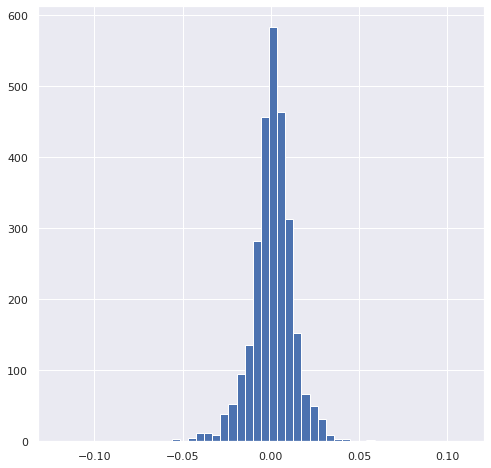

In [149]:
Erb=np.sum(dataadj*w, axis=1)
Erb.hist(bins=50)

## C) Determine el portafolio de mínima varianza.

Debemos preparar la data para simular. Por simplicidad, para el montecarlo tomaremos el libre de riesgo como 0.

### Montecarlo

In [239]:
# Monte Carlo Simulation
n = 15000

weights = np.zeros((n, 10))
exp_rtns = np.zeros(n)
exp_vols = np.zeros(n)
sharpe_ratios = np.zeros(n)
 
for i in range(n):
    weight = np.random.random(10)
    weight /= weight.sum()
    weights[i] = weight
     
    exp_rtns[i] = np.sum(dataadj.mean()*weight)*252
    exp_vols[i] = np.sqrt(np.dot(weight.T, np.dot(dataadj.cov()*252, weight)))
    sharpe_ratios[i] = exp_rtns[i] / exp_vols[i]

En base a nuestra simulación de `n` iteraciones


### Min. Varianza

Todo basado en las simulaciones Montecarlo

In [269]:
print("Min volatilidad: ", exp_vols.min())
print("Retorno esperado: ", exp_rtns[exp_vols.argmin()])
print("Ratio Sharpe", sharpe_ratios[exp_vols.argmin()])
print("Distribución: ", weights[exp_vols.argmin()])

Min volatilidad:  0.17574825075068828
Retorno esperado:  0.16560753568292041
Ratio Sharpe 0.9422997667148721
Distribución:  [0.07013431 0.03118029 0.07969446 0.01169584 0.10771652 0.1247927
 0.01151469 0.3180408  0.07155573 0.17367466]


## D) Determine el portafolio óptimo Sharpe (determine Rf según el mercado seleccionado y justifique el valor calculado).

In [240]:
# maximo de ratios sharpe
print("Max Sharpe: ", sharpe_ratios.max())
# Pesos asociados al máx de sharpe
ws= weights[sharpe_ratios.argmax()]
#ws= ws.append(
print("Distribución: ", ws)


Max Sharpe:  1.1633332921489696
Distribución:  [0.23671918 0.02862831 0.25959322 0.18021203 0.10653565 0.05955743
 0.00170404 0.08087386 0.00351285 0.04266344]


### Cálculo del máximo de Sharpe

In [223]:
# importar la librería de FE
from pypfopt.efficient_frontier import EfficientFrontier
# Definimos la FE maximizando el Sharpe
r=.040 #fijo el riesgo libre en 7% que es la inflación
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=r) 

cleaned_weights = ef.clean_weights()

Los pesos de la frontera eficiente:

In [224]:
cleaned_weights

OrderedDict([(('AAPL', 'Adj Close'), 0.24675),
             (('GOOGL', 'Adj Close'), 0.0),
             (('TSLA', 'Adj Close'), 0.23414),
             (('MSFT', 'Adj Close'), 0.31143),
             (('AMZN', 'Adj Close'), 0.20769),
             (('DIS', 'Adj Close'), 0.0),
             (('GM', 'Adj Close'), 0.0),
             (('KO', 'Adj Close'), 0.0),
             (('F', 'Adj Close'), 0.0),
             (('BRK-B', 'Adj Close'), 0.0)])

**Los parámetros y resultados de la frontera eficiente:**

In [225]:
ef.portfolio_performance(verbose=True, risk_free_rate=r)

Expected annual return: 31.1%
Annual volatility: 26.0%
Sharpe Ratio: 1.04


(0.31069183175566173, 0.2595575125593429, 1.0428973104516603)


## E) Determine la frontera eficiente de riesgo retorno (10 puntos al menos) e identifique en el gráfico los resultados obtenidos de las letras B), C) y D). Comente.

### Gráfiquemos la frontera eficiente

**X marca el óptimo de Sharpe**
**◆ marca el mín de volatilidad**

Text(0, 0.5, 'Expected Return')

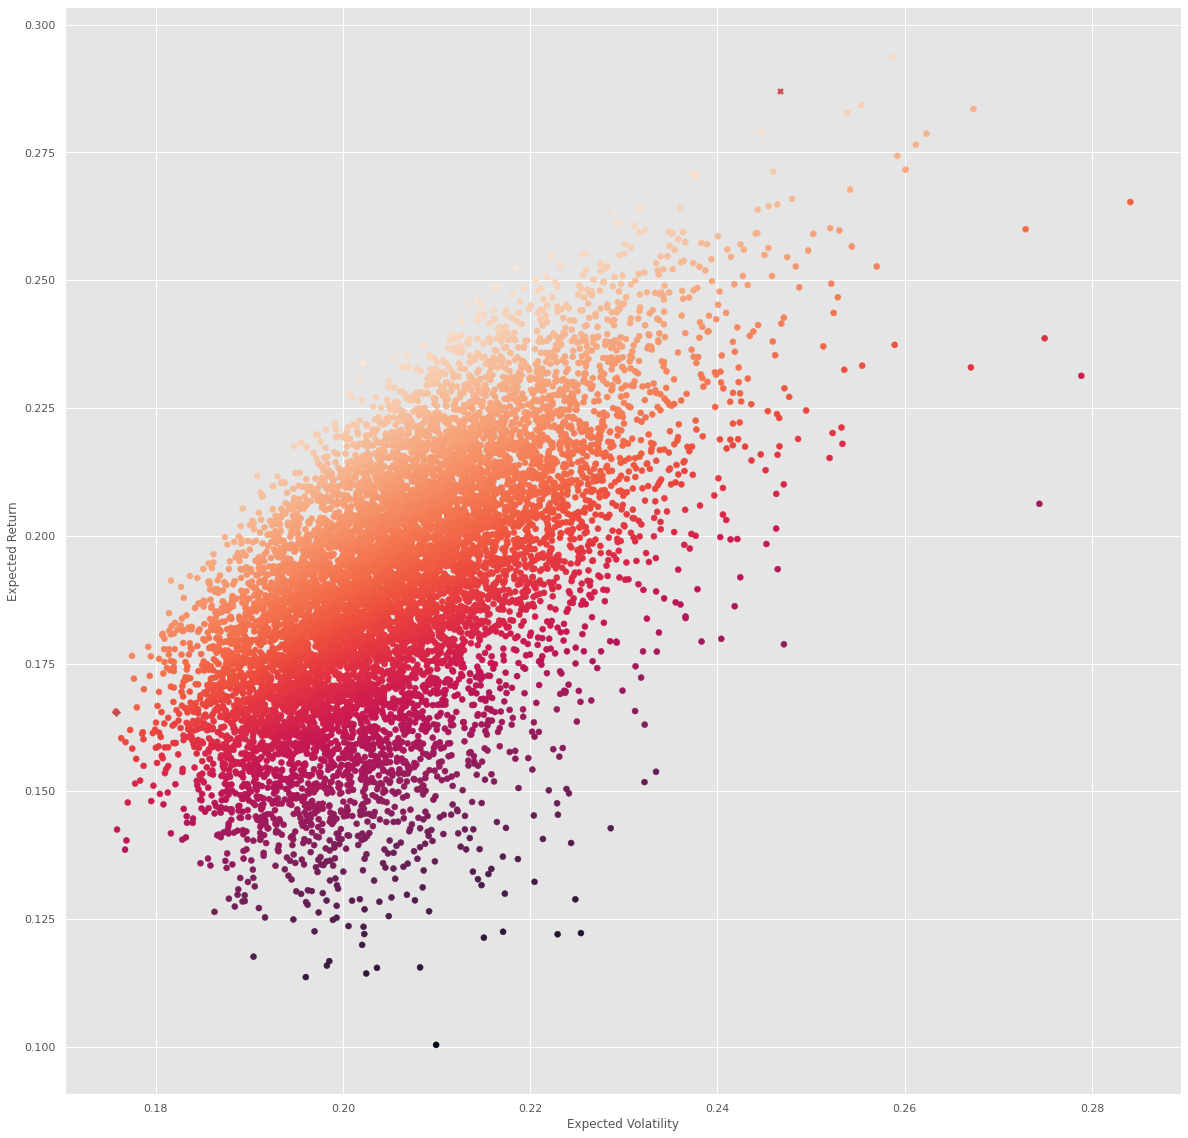

In [266]:
%matplotlib inline
 
fig, ax = plt.subplots(figsize=(20,20))
plt.style.use('ggplot')
ax.scatter(exp_vols, exp_rtns, c=sharpe_ratios)
ax.scatter(exp_vols[sharpe_ratios.argmax()], exp_rtns[sharpe_ratios.argmax()], c='r', marker='X')
ax.scatter(exp_vols.min(), exp_rtns[exp_vols.argmin()], c='r', marker='D')
ax.set_xlabel('Expected Volatility')
ax.set_ylabel('Expected Return')
